In [48]:
import numpy as np
import pandas as pd
import os
from skimage.io import imread
import cv2 as cv
from pathlib import Path
import random
from shutil import copyfile, rmtree
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
softmax = torch.nn.Softmax(dim=1)
device = torch.device("cuda")
device

device(type='cuda')

In [3]:
def load_data(input_dir, newSize=(64,64)):
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)#zwraca ndarry postaci xSize x ySize x colorDepth
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
                img = img / 255#normalizacja
                train_img.append(img)
        categories_count.append(count)

    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

In [58]:
torch.cuda.empty_cache()
from sklearn.model_selection import train_test_split
data_size = int(224/4)

data_train = load_data("plantVillageCorn",newSize=(data_size,data_size))
X = data_train['values']
y = data_train['labels']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_le = LabelEncoder()
y_train_enc = class_le.fit_transform(y_train)
y_test_enc = class_le.fit_transform(y_test)

X_train = X_train[...,:3]
X_test = X_test[...,:3]

X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

number_of_features = X_train.shape[1]
number_of_classes = 5
batch_size = 32

In [5]:
class VGG16(nn.Module):
    def __init__(
        self, num_classes: int = 1000, init_weights: bool = True, dropout: float = 0.5
    ) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
from torch.utils.data import Dataset


class CustomTensorDataset(Dataset):
    def __init__(self, tensors):
        self.tensors = tensors

    def __getitem__(self, index):
        x = self.tensors[0][index]
        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].shape[0]

In [7]:
X_train.shape

(3081, 3, 56, 56)

In [8]:
dataset = CustomTensorDataset((X_train, y_train_enc))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = CustomTensorDataset((X_test, y_test_enc))
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
model = VGG16().to(device=device)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0009)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=0.00001)

In [10]:
costs = []
train_acc = []
test_acc = []

In [11]:
X_test.shape

(771, 3, 56, 56)

In [12]:
test_acc = []
 
def test(epoch):
  model.eval()
  correct=0
  total=0

  with torch.no_grad():
    for i, (imgs, labels) in enumerate(test_dataloader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs.float())

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
      del imgs, labels, outputs
  acc = correct/total
  test_acc.append(acc)
 
  print('Test Accuracy: %.3f'%(acc))

  return acc

In [13]:
train_acc = []
train_loss = []

def train(epoch):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0

  for i, (imgs, labels) in enumerate(dataloader):
    #move tensors to device
    imgs = imgs.to(device)
    labels = labels.to(device)

    #Forward pass
    outputs = model(imgs.float())
    loss = criterion(outputs, labels)

    #Bacward & opt
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    #
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  loss = running_loss/len(dataloader)
  acc = correct/total

  train_acc.append(acc)
  train_loss.append(loss)
  print('Train Accuracy: %.3f | Loss: %.3f'%(acc, loss))

  scheduler.step()

  return acc, loss

In [14]:
total_step = len(dataloader)

vgg_train_acc = []
vgg_train_loss = []
vgg_test_acc = []

for epoch in range(100):
    tr_acc, tr_loss = train(epoch)
    vgg_test_acc.append(test(epoch))
    vgg_train_acc.append(tr_acc)
    vgg_train_loss.append(tr_loss)


Epoch : 0
Train Accuracy: 0.410 | Loss: 3.352
Test Accuracy: 0.407

Epoch : 1
Train Accuracy: 0.512 | Loss: 1.054
Test Accuracy: 0.429

Epoch : 2
Train Accuracy: 0.538 | Loss: 0.973
Test Accuracy: 0.590

Epoch : 3
Train Accuracy: 0.624 | Loss: 0.828
Test Accuracy: 0.721

Epoch : 4
Train Accuracy: 0.710 | Loss: 0.707
Test Accuracy: 0.687

Epoch : 5
Train Accuracy: 0.764 | Loss: 0.544
Test Accuracy: 0.791

Epoch : 6
Train Accuracy: 0.791 | Loss: 0.493
Test Accuracy: 0.835

Epoch : 7
Train Accuracy: 0.824 | Loss: 0.421
Test Accuracy: 0.866

Epoch : 8
Train Accuracy: 0.855 | Loss: 0.366
Test Accuracy: 0.870

Epoch : 9
Train Accuracy: 0.857 | Loss: 0.355
Test Accuracy: 0.885

Epoch : 10
Train Accuracy: 0.782 | Loss: 0.577
Test Accuracy: 0.751

Epoch : 11
Train Accuracy: 0.808 | Loss: 0.485
Test Accuracy: 0.870

Epoch : 12
Train Accuracy: 0.830 | Loss: 0.432
Test Accuracy: 0.826

Epoch : 13
Train Accuracy: 0.852 | Loss: 0.379
Test Accuracy: 0.889

Epoch : 14
Train Accuracy: 0.868 | Loss: 0.

In [15]:
torch.save(model.state_dict(), "./model_params/vgg16-platVillageCorn")

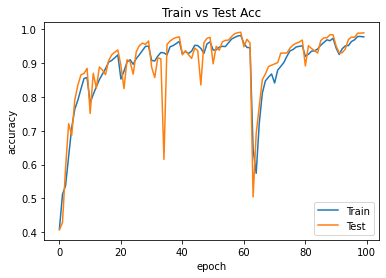

In [16]:
plt.plot(vgg_train_acc)
plt.plot(vgg_test_acc)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Train", "Test"])
plt.title("Train vs Test Acc")

plt.show()

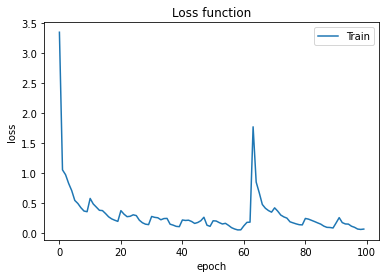

In [17]:
plt.plot(vgg_train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train"])
plt.title("Loss function")

plt.show()

# ResNet

In [74]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [78]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * 4, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [79]:
model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0009)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=0.00001)

In [80]:
total_step = len(dataloader)

resnet_train_acc = []
resnet_train_loss = []
resnet_test_acc = []

for epoch in range(100):
    tr_acc, tr_loss = train(epoch)
    resnet_test_acc.append(test(epoch))
    resnet_train_acc.append(tr_acc)
    resnet_train_loss.append(tr_loss)


Epoch : 0
Train Accuracy: 0.567 | Loss: 1.097
Test Accuracy: 0.760

Epoch : 1
Train Accuracy: 0.813 | Loss: 0.478
Test Accuracy: 0.838

Epoch : 2
Train Accuracy: 0.858 | Loss: 0.362
Test Accuracy: 0.750

Epoch : 3
Train Accuracy: 0.898 | Loss: 0.275
Test Accuracy: 0.891

Epoch : 4
Train Accuracy: 0.906 | Loss: 0.232
Test Accuracy: 0.879

Epoch : 5
Train Accuracy: 0.928 | Loss: 0.178
Test Accuracy: 0.933

Epoch : 6
Train Accuracy: 0.939 | Loss: 0.147
Test Accuracy: 0.957

Epoch : 7
Train Accuracy: 0.965 | Loss: 0.116
Test Accuracy: 0.955

Epoch : 8
Train Accuracy: 0.976 | Loss: 0.073
Test Accuracy: 0.985

Epoch : 9
Train Accuracy: 0.982 | Loss: 0.053
Test Accuracy: 0.987

Epoch : 10
Train Accuracy: 0.896 | Loss: 0.287
Test Accuracy: 0.913

Epoch : 11
Train Accuracy: 0.867 | Loss: 0.341
Test Accuracy: 0.841

Epoch : 12
Train Accuracy: 0.906 | Loss: 0.290
Test Accuracy: 0.457

Epoch : 13
Train Accuracy: 0.795 | Loss: 0.545
Test Accuracy: 0.824

Epoch : 14
Train Accuracy: 0.876 | Loss: 0.

In [82]:
torch.save(model.state_dict(), "./model_params/resnet-platVillageCorn")

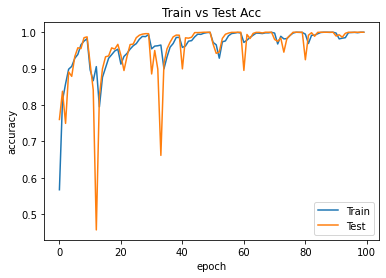

In [83]:
plt.plot(resnet_train_acc)
plt.plot(resnet_test_acc)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Train", "Test"])
plt.title("Train vs Test Acc")

plt.show()

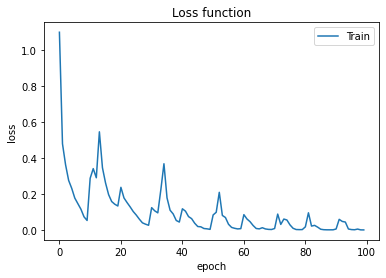

In [84]:
plt.plot(resnet_train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train"])
plt.title("Loss function")

plt.show()

# AlexNet

In [91]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5,padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size = 3, stride = 2)
            )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        return x

In [92]:
model = AlexNet().to(device)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0009)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=0.00001)

In [93]:
total_step = len(dataloader)

alexnet_train_acc = []
alexnet_train_loss = []
alexnet_test_acc = []

for epoch in range(100):
    tr_acc, tr_loss = train(epoch)
    alexnet_test_acc.append(test(epoch))
    alexnet_train_acc.append(tr_acc)
    alexnet_train_loss.append(tr_loss)


Epoch : 0
Train Accuracy: 0.622 | Loss: 1.437
Test Accuracy: 0.618

Epoch : 1
Train Accuracy: 0.797 | Loss: 0.534
Test Accuracy: 0.660

Epoch : 2
Train Accuracy: 0.825 | Loss: 0.432
Test Accuracy: 0.685

Epoch : 3
Train Accuracy: 0.843 | Loss: 0.410
Test Accuracy: 0.783

Epoch : 4
Train Accuracy: 0.853 | Loss: 0.361
Test Accuracy: 0.731

Epoch : 5
Train Accuracy: 0.881 | Loss: 0.286
Test Accuracy: 0.736

Epoch : 6
Train Accuracy: 0.903 | Loss: 0.255
Test Accuracy: 0.920

Epoch : 7
Train Accuracy: 0.911 | Loss: 0.213
Test Accuracy: 0.919

Epoch : 8
Train Accuracy: 0.926 | Loss: 0.177
Test Accuracy: 0.945

Epoch : 9
Train Accuracy: 0.935 | Loss: 0.166
Test Accuracy: 0.951

Epoch : 10
Train Accuracy: 0.875 | Loss: 0.356
Test Accuracy: 0.841

Epoch : 11
Train Accuracy: 0.877 | Loss: 0.336
Test Accuracy: 0.870

Epoch : 12
Train Accuracy: 0.879 | Loss: 0.329
Test Accuracy: 0.908

Epoch : 13
Train Accuracy: 0.912 | Loss: 0.268
Test Accuracy: 0.952

Epoch : 14
Train Accuracy: 0.925 | Loss: 0.

In [94]:
torch.save(model.state_dict(), "./model_params/alexnet-platVillageCorn")

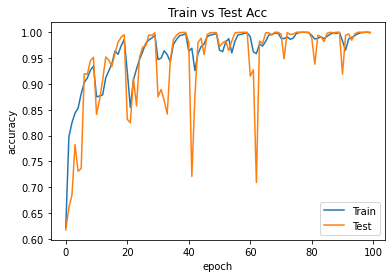

In [95]:
plt.plot(alexnet_train_acc)
plt.plot(alexnet_test_acc)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Train", "Test"])
plt.title("Train vs Test Acc")

plt.show()

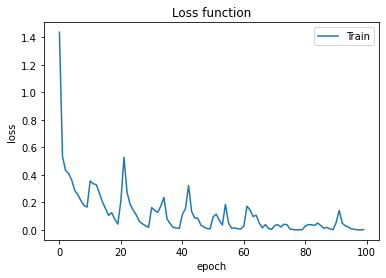

In [96]:
plt.plot(alexnet_train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train"])
plt.title("Loss function")

plt.show()